# Battle of Neighborhoods: Suggesting Restaurant Location in Vancouver

### Table of Contents

1. Use Beautiful Soap and Nominatim from Geopy to generate the dataset
2. Explore neighborhoods in Vancouver
3. Analyze data in Neighborhoods
4. Cluster Neighborhoods
5. Examine Clusters

## 1. Use Beautiful Soap and Nominatim from Geopy to generate the dataset

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [2]:
import pandas as pd
from bs4 import BeautifulSoup
import requests

In [3]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.0.2


#### Use Beautiful Soap for scraping page on Wikipedia and get postal codes in Vancouver

In [4]:
# Using Beautiful Soup
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_V').text
soup = BeautifulSoup(source, 'lxml') 

# Getting the column names con column_names
table = soup.find('table')

table_body = soup.find('tbody')
table_rows = table_body.find_all('tr')

list_of_rows = []
row  = ''

for tr in table_rows:
    table_cols = tr.find_all('td')
    for td in table_cols:
        pos_cod = td.find('b').text
        a_hrefs = td.find_all('a')
        if len(a_hrefs) > 1:
            for i, a_href in zip(range(len(a_hrefs)), a_hrefs):
                neighborhood = a_href.text
                if i == 0:
                    city = neighborhood
                else:
                    row = [pos_cod, city, neighborhood]
                    list_of_rows.append(row)
        else:
            for a_href in a_hrefs:
                city = a_href.text
                row = [pos_cod, city, 'Not assigned']
                list_of_rows.append(row) 

column_names = ['PostalCode', 'City', 'Neighborhood']

# Creates df DataFrame with the data
df=pd.DataFrame(list_of_rows, columns=column_names)
df.head(10)


,PostalCode,City,Neighborhood
0,V1A,Kimberley,Not assigned
1,V2A,Penticton,Not assigned
2,V3A,Langley Township,Not assigned
3,V4A,Surrey,Not assigned
4,V5A,Burnaby,Government Road
5,V5A,Burnaby,Lake City
6,V5A,Burnaby,SFU
7,V5A,Burnaby,Burnaby Mountain
8,V6A,Vancouver,Strathcona
9,V6A,Vancouver,Chinatown


#### Select postal codes from Vancouver and grouping neighborhoods with the same postal code

In [5]:
# Selects rows where City == 'Vancouver'
df = df[df.City == 'Vancouver']
print(df.shape)
df.head(10)

(70, 3)


,PostalCode,City,Neighborhood
8,V6A,Vancouver,Strathcona
9,V6A,Vancouver,Chinatown
10,V6A,Vancouver,Downtown Eastside
23,V6B,Vancouver,Downtown
24,V6B,Vancouver,Gastown
25,V6B,Vancouver,Harbour Centre
26,V6B,Vancouver,International Village
27,V6B,Vancouver,Victory Square
28,V6B,Vancouver,Yaletown
42,V6C,Vancouver,Waterfront


In [6]:
df2 = df
# Data Frame A contains the rows with Neighborhoods concatenated *with same Postal Code*
df2=df.groupby('PostalCode')['Neighborhood'].apply(lambda tags:', '.join(tags)).to_frame().reset_index() 
df2.head()

,PostalCode,Neighborhood
0,V5K,Hastings-Sunrise
1,V5L,Grandview-Woodland
2,V5M,"Hastings-Sunrise, Renfrew-Collingwood"
3,V5N,"Grandview-Woodland, Kensington-Cedar Cottage"
4,V5P,"Kensington-Cedar Cottage, Victoria-Fraserview"


#### Use Nominatim from Geopy and get latitude and longitude for each postal code

In [7]:
from  geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_application")

latitude_list = []
longitude_list = []

for neigh, zipcode in zip(df2.Neighborhood, df2.PostalCode):
    try:
        #postal_code = neigh + ", Vancouver, Ontario"
        loc = geolocator.geocode(zipcode)
        latitude = loc.latitude
        longitude = loc.longitude
    except:
        latitude = None
        longitude = None

    latitude_list.append(latitude)
    longitude_list.append(longitude)
    

In [8]:
df2['Latitude'] = latitude_list
df2['Longitude'] = longitude_list

In [9]:
neighborhoods = df2.dropna().reset_index(drop = True)

In [11]:
neighborhoods.head(30)

,PostalCode,Neighborhood,Latitude,Longitude
0,V5K,Hastings-Sunrise,49.281967,-123.040004
1,V5L,Grandview-Woodland,49.278839,-123.066843
2,V5M,"Hastings-Sunrise, Renfrew-Collingwood",49.258053,-123.040155
3,V5N,"Grandview-Woodland, Kensington-Cedar Cottage",49.253451,-123.066309
4,V5P,"Kensington-Cedar Cottage, Victoria-Fraserview",49.222370,-123.068315
5,V5R,Renfrew-Collingwood,49.240005,-123.041204
6,V5S,Killarney,49.215677,-123.041565
7,V5T,Mount Pleasant,49.261967,-123.091194
8,V5V,"Kensington-Cedar Cottage, Riley Park-Little Mo...",49.247634,-123.090605
9,V5W,"Riley Park-Little Mountain, Kensington-Cedar C...",49.232961,-123.091285


#### Import needed libraries

In [12]:
# Importing libraries
 
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### Use geopy library to get the latitude and longitude values of Vancouver.

In [13]:
address = 'Vancouver, BC'

geolocator = Nominatim(user_agent="Vancouver_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Vancouver are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Vancouver are 49.2608724, -123.1139529.


In [14]:
# create map of Toronto using latitude and longitude values
map_Vancouver = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Vancouver)  
    
map_Vancouver

#### Define Foursquare Credentials and Version

In [15]:
CLIENT_ID = 'CN3WUMRTROO25C3UC3HVQICM024SNBGW2A4NGDHGUKFKGAIF' # your Foursquare ID
CLIENT_SECRET = 'KIYGMWAWMBDQZRDDP2G1EOROHAV2M1CEO4WBPSTXRRXRMMY5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


## 2. Explore neighborhoods in Vancouver

In [16]:
# Function to get venues for all the neighborhoods in Vancouver
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
# Run the above function on each neighborhood and create a new dataframe called toronto_venues.
LIMIT = 100
vancouver_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Hastings-Sunrise
Grandview-Woodland
Hastings-Sunrise, Renfrew-Collingwood
Grandview-Woodland, Kensington-Cedar Cottage
Kensington-Cedar Cottage, Victoria-Fraserview
Renfrew-Collingwood
Killarney
Mount Pleasant
Kensington-Cedar Cottage, Riley Park-Little Mountain
Riley Park-Little Mountain, Kensington-Cedar Cottage, Oakridge, Sunset
Oakridge, Marpole, Sunset
Mount Pleasant, Riley Park-Little Mountain
Fairview, South Cambie
Strathcona, Chinatown, Downtown Eastside
Downtown, Gastown, Harbour Centre, International Village, Victory Square, Yaletown
Waterfront, Coal Harbour, Canada Place
West End, Davie Village
West End, Stanley Park
Fairview, Granville Island, Shaughnessy
Shaughnessy, Kitsilano, Quilchena
Kitsilano, Greektown
Arbutus Ridge, Dunbar-Southlands
Shaughnessy, Oakridge, Kerrisdale, Arbutus Ridge
Kerrisdale, Dunbar-Southlands, Musqueam
Kerrisdale, Oakridge, Marpole
Kitsilano, West Point Grey, Jericho
UBC
Downtown
Bentall Centre
Pacific Centre


#### Dataset generated with all the venues in every neighborhood

In [18]:
# To check the size of the resulting dataframe
print(vancouver_venues.shape)
vancouver_venues.head()

(971, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hastings-Sunrise,49.281967,-123.040004,The Fair at the PNE,49.282971,-123.042109,Fair
1,Hastings-Sunrise,49.281967,-123.040004,Livestock Barns,49.284037,-123.039278,Farm
2,Hastings-Sunrise,49.281967,-123.040004,Wooden Roller Coaster,49.281744,-123.035128,Theme Park Ride / Attraction
3,Hastings-Sunrise,49.281967,-123.040004,Pacific Coliseum,49.285823,-123.042727,Hockey Arena
4,Hastings-Sunrise,49.281967,-123.040004,Plaza Beer Garden,49.283701,-123.038785,Beer Garden


In [19]:
# To check how many venues were returned for each neighborhood
vancouver_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Arbutus Ridge, Dunbar-Southlands",3,3,3,3,3,3
Bentall Centre,100,100,100,100,100,100
Downtown,89,89,89,89,89,89
"Downtown, Gastown, Harbour Centre, International Village, Victory Square, Yaletown",100,100,100,100,100,100
"Fairview, Granville Island, Shaughnessy",24,24,24,24,24,24
"Fairview, South Cambie",24,24,24,24,24,24
Grandview-Woodland,37,37,37,37,37,37
"Grandview-Woodland, Kensington-Cedar Cottage",15,15,15,15,15,15
Hastings-Sunrise,23,23,23,23,23,23


In [20]:
# How many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(vancouver_venues['Venue Category'].unique())))

There are 187 uniques categories.


## 3. Analyze data in Neighborhoods

In [21]:
# To verify if there are some Venue Category with the word "Mexican Restaurant"
v_mexican_rest = vancouver_venues.loc[vancouver_venues['Venue Category'] == 'Mexican Restaurant']
v_mexican_rest

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
330,"Downtown, Gastown, Harbour Centre, Internation...",49.274763,-123.118093,Salsa & Agave Mexican Grill,49.273922,-123.121633,Mexican Restaurant
335,"Downtown, Gastown, Harbour Centre, Internation...",49.274763,-123.118093,Fayuca,49.276808,-123.120167,Mexican Restaurant
361,"Downtown, Gastown, Harbour Centre, Internation...",49.274763,-123.118093,Patron Tacos & Cantina,49.278546,-123.115458,Mexican Restaurant
543,"West End, Davie Village",49.284835,-123.126279,Chipotle Mexican Grill,49.281818,-123.121535,Mexican Restaurant
686,Downtown,49.278043,-123.127778,Molli Cafe,49.278835,-123.129814,Mexican Restaurant
700,Downtown,49.278043,-123.127778,The Mexican,49.278778,-123.123953,Mexican Restaurant
742,Downtown,49.278043,-123.127778,La Cantina Taco Cartel,49.279460,-123.123364,Mexican Restaurant
759,Downtown,49.278043,-123.127778,Los Amigos Taqueria,49.280753,-123.131778,Mexican Restaurant
768,Downtown,49.278043,-123.127778,La Churreria,49.280521,-123.131218,Mexican Restaurant
918,Pacific Centre,49.282412,-123.119216,Chipotle Mexican Grill,49.281818,-123.121535,Mexican Restaurant


In [22]:
# Visualize data in numbers and prepare for plot data
v_mexican_rest_grouped = vancouver_venues[vancouver_venues['Venue Category'].str.contains('Mexican Restaurant')].groupby('Neighborhood').count()
v_mexican_rest_grouped = v_mexican_rest_grouped['Venue Category'].sort_values(ascending = False).transpose()
v_mexican_rest_grouped

Neighborhood
Downtown                                                                              5
Downtown, Gastown, Harbour Centre, International Village, Victory Square, Yaletown    3
West End, Davie Village                                                               1
Pacific Centre                                                                        1
Name: Venue Category, dtype: int64

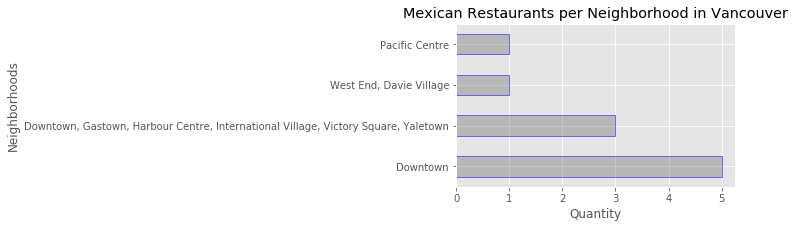

In [23]:
# plot data

v_mexican_rest_grouped.plot(kind='barh', figsize=(5, 3), color=(0.3, 0.3, 0.3, 0.3),  edgecolor='blue')
plt.xlabel('Quantity') # add to x-label to the plot
plt.ylabel('Neighborhoods') # add y-label to the plot
plt.title('Mexican Restaurants per Neighborhood in Vancouver') # add title to the plot
plt.show()

In [24]:
# To count Venue Category with the words "Mexican Restaurant" 
vancouver_venues.loc[vancouver_venues['Venue Category'] == 'Mexican Restaurant'].groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Mexican Restaurant,10,10,10,10,10,10


In [25]:
# List of ALL the restaurants in the Vancouver Zone we are analyzing
v_qty_restaurants = vancouver_venues[vancouver_venues['Venue Category'].str.contains('Restaurant')].groupby('Venue Category').count()
v_qty_restaurants = v_qty_restaurants['Neighborhood'].sort_values().transpose()
v_qty_restaurants

Venue Category
New American Restaurant           1
Hotpot Restaurant                 1
Himalayan Restaurant              1
Korean Restaurant                 1
Lebanese Restaurant               1
Filipino Restaurant               1
Japanese Curry Restaurant         1
Falafel Restaurant                1
Portuguese Restaurant             1
Dim Sum Restaurant                1
Comfort Food Restaurant           1
Cajun / Creole Restaurant         1
Caribbean Restaurant              2
Australian Restaurant             2
Ethiopian Restaurant              2
Hawaiian Restaurant               3
Malay Restaurant                  4
Mediterranean Restaurant          4
Ramen Restaurant                  4
Fast Food Restaurant              4
Vegetarian / Vegan Restaurant     5
Greek Restaurant                  6
Middle Eastern Restaurant         6
Thai Restaurant                   8
French Restaurant                 9
Asian Restaurant                  9
Mexican Restaurant               10
Indian Restau

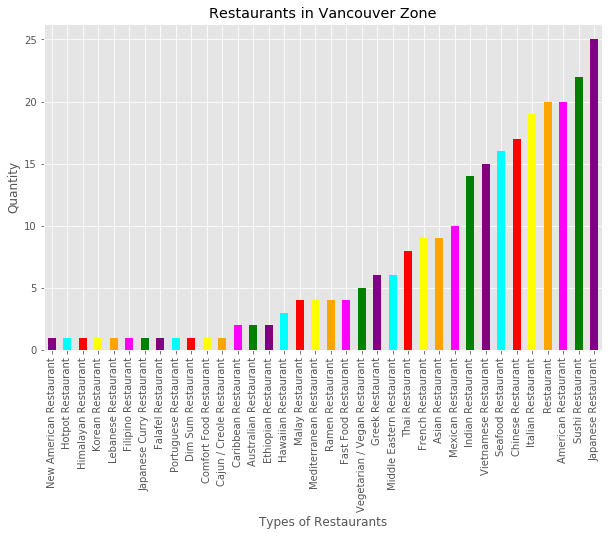

In [26]:
# step 1: prepare data to plot
v_qty_restaurants = vancouver_venues[vancouver_venues['Venue Category'].str.contains('Restaurant')].groupby('Venue Category').count()
v_qty_restaurants = v_qty_restaurants['Neighborhood'].sort_values().transpose()

# step 2: plot data
v_qty_restaurants.plot(kind='bar', figsize=(10, 6), color = ['purple', 'cyan', 'red', 'yellow', 'orange', 'magenta', 'green'])

plt.xlabel('Types of Restaurants') # add to x-label to the plot
plt.ylabel('Quantity') # add y-label to the plot
plt.title('Restaurants in Vancouver Zone') # add title to the plot
plt.show()

#### Prepare data for k-means algorithm

In [27]:
# one hot encoding
vancouver_onehot = pd.get_dummies(vancouver_venues[['Venue Category']], prefix="", prefix_sep="")
vancouver_onehot.head(30)

,Accessories Store,Airport Terminal,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bank,Bar,Beach,Beer Bar,Beer Garden,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Casino,Child Care Service,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cruise,Cycle Studio,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,Gay Bar,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hockey Arena,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Inn,Insurance Office,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Other Great Outdoors,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plaza,Poke Place,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Soccer Field,Soccer Stadium,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [28]:
# add neighborhood column back to dataframe
vancouver_onehot['Neighborhood'] = vancouver_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [vancouver_onehot.columns[-1]] + list(vancouver_onehot.columns[:-1])
vancouver_onehot = vancouver_onehot[fixed_columns]

vancouver_onehot.head()

,Neighborhood,Accessories Store,Airport Terminal,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bank,Bar,Beach,Beer Bar,Beer Garden,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Casino,Child Care Service,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cruise,Cycle Studio,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,Gay Bar,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hockey Arena,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Inn,Insurance Office,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Other Great Outdoors,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plaza,Poke Place,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Soccer Field,Soccer Stadium,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
0,Hastings-Sunrise,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Hastings-Sunrise,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Hastings-Sunrise,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,Hastings-Sunrise,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [29]:
# To group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
vancouver_grouped = vancouver_onehot.groupby('Neighborhood').mean().reset_index()
vancouver_grouped

,Neighborhood,Accessories Store,Airport Terminal,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bank,Bar,Beach,Beer Bar,Beer Garden,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Casino,Child Care Service,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cruise,Cycle Studio,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,Gay Bar,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hockey Arena,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Inn,Insurance Office,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Other Great Outdoors,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plaza,Poke Place,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Soccer Field,Soccer Stadium,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
0,"Arbutus Ridge, Dunbar-Southlands",0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00

In [30]:
vancouver_grouped.head(5)

,Neighborhood,Accessories Store,Airport Terminal,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bank,Bar,Beach,Beer Bar,Beer Garden,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Casino,Child Care Service,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cruise,Cycle Studio,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,Gay Bar,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hockey Arena,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Inn,Insurance Office,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Other Great Outdoors,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plaza,Poke Place,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Soccer Field,Soccer Stadium,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
0,"Arbutus Ridge, Dunbar-Southlands",0.00,0.00,0.000000,0.0,0.000000,0.00,0.00,0.00,0.00,0.333333,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.000,0.00,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.333333,0.00,0.0,0.00,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,0.0,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.333333,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.00,0.00,0.000000,0.0,0.00,0.00,0.00000,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.0
1,Bentall Centre,0.00,0.01,0.060000,0.0,0.010000,0.01,0.00,0.00,0.01,0.000000,0.0,0.01,0.0,0.00,0.0,0.0,0.01,0.020,0.00,0.0,0.01,0.010000,0.000000,0.0,0.000000,0.01,0.040000,0.0000

#### Sort top 10 venues for each neighborhood

In [31]:
# Function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
# To create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = vancouver_grouped['Neighborhood']

for ind in np.arange(vancouver_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(vancouver_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Arbutus Ridge, Dunbar-Southlands",Caribbean Restaurant,Bakery,Italian Restaurant,Zoo Exhibit,Farmers Market,Food Court,Food & Drink Shop,Fish Market,Fish & Chips Shop,Financial or Legal Service
1,Bentall Centre,Hotel,American Restaurant,Coffee Shop,Dessert Shop,Café,Restaurant,Steakhouse,Seafood Restaurant,Cosmetics Shop,Miscellaneous Shop
2,Downtown,Hotel,Mexican Restaurant,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Bakery,Café,Hostel,Diner,Gay Bar
3,"Downtown, Gastown, Harbour Centre, Internation...",Hotel,Café,Restaurant,Italian Restaurant,Coffee Shop,Yoga Studio,Seafood Restaurant,Bakery,Vegetarian / Vegan Restaurant,Japanese Restaurant
4,"Fairview, Granville Island, Shaughnessy",Breakfast Spot,Coffee Shop,Furniture / Home Store,Bakery,Bus Stop,Gourmet Shop,Lingerie Store,Cajun / Creole Restaurant,Café,Burger Joint
5,"Fairview, South Cambie",Sushi Restaurant,Park,Bus Stop,Chinese Restaurant,Greek Restaurant,Bubble Tea Shop,Coffee Shop,Sporting Goods Shop,Liquor Store,Gourmet Shop
6,Grandview-Woodland,Coffee Shop,Asian Restaurant,Pizza Place,Theater,Brewery,Italian Restaurant,Sushi Restaurant,Japanese Restaurant,Convenience Store,Breakfast Spot
7,"Grandview-Woodland, Kensington-Cedar Cottage",Café,Dog Run,Gym / Fitness Center,Child Care Service,Church,Lake,Bookstore,Concert Hall,Beach,Gym
8,Hastings-Sunrise,Event Space,Theme Park,Hockey Arena,Stadium,Theme Park Ride / Attraction,Sandwich Place,Market,Farm,Fair,Beer Garden
9,"Hastings-Sunrise, Renfrew-Collingwood",Coffee Shop,Grocery Store,Office,Japanese Restaurant,Sporting Goods Shop,Insurance Office,Sandwich Place,Bus Station,Pizza Place,Furniture / Home Store


In [33]:
# Check if the top 10 venues of each Neighborhood really have the venues listed. 
# If no venues exist, then assign a '-' to the position so we can visualize that there are no venues.

columns.remove('Neighborhood')
#print(columns)
for ind in np.arange(neighborhoods_venues_sorted.shape[0]):
    neighborhood_venue = neighborhoods_venues_sorted.loc[ind, 'Neighborhood']
    for col_top10 in columns:
        col_venue = neighborhoods_venues_sorted.loc[ind, col_top10]
        onehot_venue = vancouver_grouped.loc[vancouver_grouped['Neighborhood'] == neighborhood_venue, col_venue]
        if (onehot_venue[ind] > 0.0):
            pass
        else:
            neighborhoods_venues_sorted.loc[ind, col_top10] = '-'

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Arbutus Ridge, Dunbar-Southlands",Caribbean Restaurant,Bakery,Italian Restaurant,-,-,-,-,-,-,-
1,Bentall Centre,Hotel,American Restaurant,Coffee Shop,Dessert Shop,Café,Restaurant,Steakhouse,Seafood Restaurant,Cosmetics Shop,Miscellaneous Shop
2,Downtown,Hotel,Mexican Restaurant,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Bakery,Café,Hostel,Diner,Gay Bar
3,"Downtown, Gastown, Harbour Centre, Internation...",Hotel,Café,Restaurant,Italian Restaurant,Coffee Shop,Yoga Studio,Seafood Restaurant,Bakery,Vegetarian / Vegan Restaurant,Japanese Restaurant
4,"Fairview, Granville Island, Shaughnessy",Breakfast Spot,Coffee Shop,Furniture / Home Store,Bakery,Bus Stop,Gourmet Shop,Lingerie Store,Cajun / Creole Restaurant,Café,Burger Joint
5,"Fairview, South Cambie",Sushi Restaurant,Park,Bus Stop,Chinese Restaurant,Greek Restaurant,Bubble Tea Shop,Coffee Shop,Sporting Goods Shop,Liquor Store,Gourmet Shop
6,Grandview-Woodland,Coffee Shop,Asian Restaurant,Pizza Place,Theater,Brewery,Italian Restaurant,Sushi Restaurant,Japanese Restaurant,Convenience Store,Breakfast Spot
7,"Grandview-Woodland, Kensington-Cedar Cottage",Café,Dog Run,Gym / Fitness Center,Child Care Service,Church,Lake,Bookstore,Concert Hall,Beach,Gym
8,Hastings-Sunrise,Event Space,Theme Park,Hockey Arena,Stadium,Theme Park Ride / Attraction,Sandwich Place,Market,Farm,Fair,Beer Garden
9,"Hastings-Sunrise, Renfrew-Collingwood",Coffee Shop,Grocery Store,Office,Japanese Restaurant,Sporting Goods Shop,Insurance Office,Sandwich Place,Bus Station,Pizza Place,Furniture / Home Store


## 4. Cluster Neighborhoods

#### Find best k

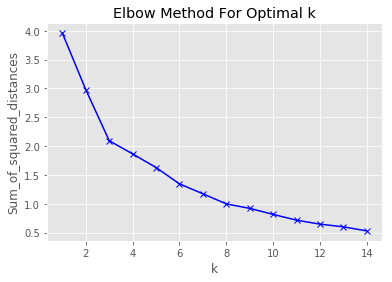

In [34]:
vancouver_grouped_clustering2 = vancouver_grouped.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(vancouver_grouped_clustering2)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### The best k for clustering is kclusters = 6

In [35]:
# To run k-means to cluster the neighborhood into  clusters.

# set number of clusters
kclusters = 6

vancouver_grouped_clustering = vancouver_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vancouver_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:50] 

array([4, 5, 5, 5, 5, 0, 0, 5, 5, 0, 0, 0, 0, 5, 0, 0, 1, 5, 0, 5, 5, 5,
       0, 0, 3, 5, 2, 5, 5, 5], dtype=int32)

In [36]:
# To create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

vancouver_merged = neighborhoods

# merge vancouver_grouped with toronto_data to add latitude/longitude for each neighborhood
vancouver_merged = vancouver_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

vancouver_merged.head(40) # check the last columns!

,PostalCode,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,V5K,Hastings-Sunrise,49.281967,-123.040004,5,Event Space,Theme Park,Hockey Arena,Stadium,Theme Park Ride / Attraction,Sandwich Place,Market,Farm,Fair,Beer Garden
1,V5L,Grandview-Woodland,49.278839,-123.066843,0,Coffee Shop,Asian Restaurant,Pizza Place,Theater,Brewery,Italian Restaurant,Sushi Restaurant,Japanese Restaurant,Convenience Store,Breakfast Spot
2,V5M,"Hastings-Sunrise, Renfrew-Collingwood",49.258053,-123.040155,0,Coffee Shop,Grocery Store,Office,Japanese Restaurant,Sporting Goods Shop,Insurance Office,Sandwich Place,Bus Station,Pizza Place,Furniture / Home Store
3,V5N,"Grandview-Woodland, Kensington-Cedar Cottage",49.253451,-123.066309,5,Café,Dog Run,Gym / Fitness Center,Child Care Service,Church,Lake,Bookstore,Concert Hall,Beach,Gym
4,V5P,"Kensington-Cedar Cottage, Victoria-Fraserview",49.222370,-123.068315,0,Pizza Place,Park,Indian Restaurant,Motorcycle Shop,Pet Store,Pharmacy,Convenience Store,Middle Eastern Restaurant,Sandwich Place,Café
5,V5R,Renfrew-Collingwood,49.240005,-123.041204,5,Hotel,Asian Restaurant,Fish & Chips Shop,Bus Stop,Bar,Park,-,-,-,-
6,V5S,Killarney,49.215677,-123.041565,0,Shopping Mall,Juice Bar,Sushi Restaurant,Coffee Shop,Fast Food Restaurant,Salon / Barbershop,Sandwich Place,Chinese Restaurant,Bank,Bakery
7,V5T,Mount Pleasant,49.261967,-123.091194,5,Ethiopian Restaurant,Sushi Restaurant,Grocery Store,Pizza Place,Liquor Store,Market,Sandwich Place,Sports Bar,Japanese Restaurant,Pub
8,V5V,"Kensington-Cedar Cottage, Riley Park-Little Mo...",49.247634,-123.090605,0,Coffee Shop,Bus Stop,Chinese Restaurant,Vietnamese Restaurant,Gourmet Shop,Greek Restaurant,Café,Sandwich Place,Filipino Restaurant,Supermarket
9,V5W,"Riley Park-Little Mountain, Kensington-Cedar C...",49.232961,-123.091285,0,Chinese Restaurant,Pizza Place,Bus Stop,Bakery,Diner,Fried Chicken Joint,Field,Fast Food Restaurant,Coffee Shop,Tea Room


In [37]:
# To visualize the resulting clusters
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(vancouver_merged['Latitude'], vancouver_merged['Longitude'], vancouver_merged['Neighborhood'], vancouver_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-6],
        fill=True,
        fill_color=rainbow[cluster-6],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

In [38]:
# Cluster 1
#cluster1_venues = vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 0, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]
#cluster1_venues

vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 0, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Grandview-Woodland,Coffee Shop,Asian Restaurant,Pizza Place,Theater,Brewery,Italian Restaurant,Sushi Restaurant,Japanese Restaurant,Convenience Store,Breakfast Spot
2,"Hastings-Sunrise, Renfrew-Collingwood",Coffee Shop,Grocery Store,Office,Japanese Restaurant,Sporting Goods Shop,Insurance Office,Sandwich Place,Bus Station,Pizza Place,Furniture / Home Store
4,"Kensington-Cedar Cottage, Victoria-Fraserview",Pizza Place,Park,Indian Restaurant,Motorcycle Shop,Pet Store,Pharmacy,Convenience Store,Middle Eastern Restaurant,Sandwich Place,Café
6,Killarney,Shopping Mall,Juice Bar,Sushi Restaurant,Coffee Shop,Fast Food Restaurant,Salon / Barbershop,Sandwich Place,Chinese Restaurant,Bank,Bakery
8,"Kensington-Cedar Cottage, Riley Park-Little Mo...",Coffee Shop,Bus Stop,Chinese Restaurant,Vietnamese Restaurant,Gourmet Shop,Greek Restaurant,Café,Sandwich Place,Filipino Restaurant,Supermarket
9,"Riley Park-Little Mountain, Kensington-Cedar C...",Chinese Restaurant,Pizza Place,Bus Stop,Bakery,Diner,Fried Chicken Joint,Field,Fast Food Restaurant,Coffee Shop,Tea Room
11,"Mount Pleasant, Riley Park-Little Mountain",Chinese Restaurant,Dessert Shop,Bakery,Sushi Restaurant,Grocery Store,Coffee Shop,-,-,-,-
12,"Fairview, South Cambie",Sushi Restaurant,Park,Bus Stop,Chinese Restaurant,Greek Restaurant,Bubble Tea Shop,Coffee Shop,Sporting Goods Shop,Liquor Store,Gourmet Shop
19,"Shaughnessy, Kitsilano, Quilchena",Coffee Shop,Thai Restaurant,American Restaurant,Pizza Place,Yoga Studio,Japanese Restaurant,Sushi Restaurant,Diner,Furniture / Home Store,Sporting Goods Shop
20,"Kitsilano, Greektown",Coffee Shop,Park,Café,Toy / Game Store,Sushi Restaurant,Beach,Restaurant,Pub,Bus Stop,Food Truck


In [39]:
# Cluster 2
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 1, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,"Kitsilano, West Point Grey, Jericho",Park,-,-,-,-,-,-,-,-,-


In [40]:
# Cluster 3
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 2, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,UBC,Trail,-,-,-,-,-,-,-,-,-


In [41]:
# Cluster 4
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 3, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,"Shaughnessy, Oakridge, Kerrisdale, Arbutus Ridge",Home Service,Bus Stop,Moving Target,Electronics Store,-,-,-,-,-,-


In [42]:
# Cluster 5
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 4, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,"Arbutus Ridge, Dunbar-Southlands",Caribbean Restaurant,Bakery,Italian Restaurant,-,-,-,-,-,-,-


In [43]:
# Cluster 6
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 5, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hastings-Sunrise,Event Space,Theme Park,Hockey Arena,Stadium,Theme Park Ride / Attraction,Sandwich Place,Market,Farm,Fair,Beer Garden
3,"Grandview-Woodland, Kensington-Cedar Cottage",Café,Dog Run,Gym / Fitness Center,Child Care Service,Church,Lake,Bookstore,Concert Hall,Beach,Gym
5,Renfrew-Collingwood,Hotel,Asian Restaurant,Fish & Chips Shop,Bus Stop,Bar,Park,-,-,-,-
7,Mount Pleasant,Ethiopian Restaurant,Sushi Restaurant,Grocery Store,Pizza Place,Liquor Store,Market,Sandwich Place,Sports Bar,Japanese Restaurant,Pub
10,"Oakridge, Marpole, Sunset",Park,History Museum,Indian Restaurant,Electronics Store,Bus Stop,-,-,-,-,-
13,"Strathcona, Chinatown, Downtown Eastside",Brewery,Bakery,Ice Cream Shop,Gastropub,Coffee Shop,Beer Bar,Liquor Store,Café,Salad Place,Food Truck
14,"Downtown, Gastown, Harbour Centre, Internation...",Hotel,Café,Restaurant,Italian Restaurant,Coffee Shop,Yoga Studio,Seafood Restaurant,Bakery,Vegetarian / Vegan Restaurant,Japanese Restaurant
15,"Waterfront, Coal Harbour, Canada Place",Coffee Shop,Boat or Ferry,Café,Hotel,American Restaurant,Food Truck,Japanese Restaurant,Bar,Pizza Place,Seafood Restaurant
16,"West End, Davie Village",Hotel,French Restaurant,Japanese Restaurant,Restaurant,Steakhouse,Food Truck,Italian Restaurant,Dessert Shop,Clothing Store,Café
17,"West End, Stanley Park",Aquarium,Park,Theme Park Ride / Attraction,Zoo Exhibit,Bus Station,Garden,Exhibit,Event Space,Music Venue,Other Great Outdoors
